In [1]:
import random
import matplotlib.pyplot as plt
import numpy as np
from numpy import linalg as LA
from numpy.matlib import repmat

In [2]:
def transform(X, mod):
    
    if mod==0:
        r_X = X[1,0:2] - X[3,0:2]
    elif mod==1:
        r_X = X[3,0:2] - X[1,0:2]
    
    r = locations[3,:] - locations[1,:]
    theta = -np.arccos(np.dot(r,r_X)/(LA.norm(r_X)*LA.norm(r)))

    c, s = np.cos(theta), np.sin(theta)
    rotation = np.array(((c, -s), (s, c)))
    translation = -np.dot(X[2,0:2], np.transpose(rotation))
    #test = np.transpose(np.dot(rotation, np.transpose(X[:,0:2]))) + repmat(translation, 4, 1)
    test = 1
    #estimate_source = np.transpose(np.dot(rotation, np.transpose(X[0,0:2])) + translation)
    estimate_source = np.dot(X[0,0:2], np.transpose(rotation)) + translation
    
    return estimate_source, test

In [54]:
MSE = []
solved = 0
unsolved = 0

for ran_idx in range(52,53):

    random.seed(ran_idx)
    np.random.seed(ran_idx)

    source = [random.uniform(-5,5),random.uniform(0,10)]
    mic1 = [-2,1]
    mic2 = [0,0]
    mic3 = [2,1]

    #source = [0,25]
    #mic1 = [-12,9]
    #mic2 = [0,0]
    #mic3 = [12,9]

    locations = np.zeros([4,2])
    locations[0] = source
    locations[1] = mic1
    locations[2] = mic2
    locations[3] = mic3

    mu = np.array([0,0,0])
    sigma = np.array([0.4,0.4,0.4])
    noise = np.random.normal(mu,sigma)

    D = np.zeros([4,4])

    for i in range(4):
        for j in range((i+1),4):
            if i == 0:
                D[i,j] = (np.sqrt((locations[i,0]-locations[j,0])**2 + (locations[i,1]-locations[j,1])**2)+ noise[j-1])**2
                D[j,i] = D[i,j]
            else:
                D[i,j] = (locations[i,0]-locations[j,0])**2 + (locations[i,1]-locations[j,1])**2
                D[j,i] = D[i,j]

    a = np.ones([1,4])/4
    J = 1/2**0.5 * np.transpose((np.eye(4) - np.ones([4,1]) * a))

    K = - LA.multi_dot([np.transpose(J), D, J])

    Lambda, U = LA.eig(K)
    
    idx = np.abs(Lambda).argsort()[::-1]
    Lambda = Lambda[idx]
    U = U[:,idx]
    
    rank = LA.matrix_rank(D)
    Lambda = Lambda[:2]
    if Lambda[1] < 0:
        Lambda[1] = - Lambda[1]
    U = np.round(U[:,:2],4)
    if U[0,0] > 0:
        U[:,0] = - U[:,0]
    
    U0 = U.copy()
    U1 = U.copy()
    
    U1[:,1] = - U1[:,1]
    
    X0 = np.dot(U0, np.sqrt(np.round(np.diag(Lambda),4)))
    X1 = np.dot(U1, np.sqrt(np.round(np.diag(Lambda),4)))
    
    estimations = np.zeros([4,2])
    mse = np.zeros([4,1])
    
    estimations[0,:], test00 = transform(X0, mod=0)
    estimations[1,:], test01 = transform(X0, mod=1)
    estimations[2,:], test10 = transform(X1, mod=0)
    estimations[3,:], test11 = transform(X1, mod=1)

    mse[0] = (estimations[0,0]-locations[0,0])**2 + (estimations[0,1]-locations[0,1])**2
    mse[1] = (estimations[1,0]-locations[0,0])**2 + (estimations[1,1]-locations[0,1])**2
    mse[2] = (estimations[2,0]-locations[0,0])**2 + (estimations[2,1]-locations[0,1])**2
    mse[3] = (estimations[3,0]-locations[0,0])**2 + (estimations[3,1]-locations[0,1])**2
    
    min_mse = np.min(mse)
    min_idx = np.argmin(mse)
    estimate_source = estimations[min_idx,:]
    
    if min_mse > 1:
        unsolved += 1
        print('fail')
    else:  
        MSE.append(min_mse)
        solved += 1
        print('success')
    
mean_MSE = np.mean(MSE)

print('Number of cases solved:', solved)
print('Number of unsolved cases:', unsolved)
print('The mean MSE of solved cases is:', mean_MSE)

success
Number of cases solved: 1
Number of unsolved cases: 0
The mean MSE of solved cases is: 0.3083330381541266


In [52]:
print(estimate_source)
print(Lambda)
print(MSE)

[4.66327635e+00 3.13096055e-03]
[25.77424981  1.60114902]
[0.3083330381541266]


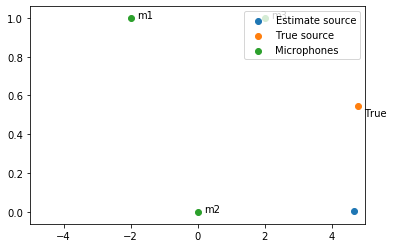

In [49]:
#import matplotlib
#matplotlib.rcParams.update({'font.size': 10.5})

plt.scatter(estimate_source[0], estimate_source[1], label='Estimate source')
plt.scatter(locations[0,0], locations[0,1], label='True source')
plt.scatter(locations[1:,0], locations[1:,1], label='Microphones')

#plt.scatter(X[:,0], X[:,1])
#plt.scatter(test0[:,0], test0[:,1])
#plt.scatter(test[:,0], test[:,1])
#print(theta)
#print(X)
#print(test)
#print(estimate_source)
plt.xlim([-5,5])
plt.legend(loc='upper right')

labels = ['True', 'm1', 'm2', 'm3']
plt.annotate('Estimation', (estimate_source[0]+0.18, estimate_source[1]-0.07))
plt.annotate(labels[0], (locations[0,0]+0.2, locations[0,1]-0.05))
for i in range(1,4):
    plt.annotate(labels[i], (locations[i,0]+0.2, locations[i,1]))

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:78: ComplexWarning: Casting complex values to real discards the imaginary part
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:79: ComplexWarning: Casting complex values to real discards the imaginary part
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:80: ComplexWarning: Casting complex values to real discards the imaginary part
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:81: ComplexWarning: Casting complex values to real discards the imaginary part
